In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2 , glob , os
import numpy as np
import matplotlib.pyplot as plt
import glob

# Load data


## preprocessing()
Dataset이 저장된 디렉토리에서 opencv를 이용하여 landmark image를 load합니다.  
load한 이미지는 resize후  numpy array 형태로 dstack되어 로드됩니다.

In [ ]:
def preprocessing(file_root,input_shape): # dataset의 디렉토리, resize할 이미지의 크기
  folder_names=[]
  images = []
  folder_names=sorted(os.listdir(path = file_root))

  for folder_name in folder_names:
    img_path = file_root + folder_name +'/'+folder_name+'_landmark.jpg'
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) # 이미지 로드 후 BGR -> RGB로 변경
    img = cv2.resize(img, dsize = input_shape) # 이미지의 사이즈들을 동일하게 조정
    images.append(img)

  images = np.array(images)
  return images, folder_names # 이미지 numpy array와 이미지의 폴더 명이 담긴 list 반환

In [ ]:
file_root = '/content/drive/Shareddrives/[DIP] Final project_cephalogram/sample/'
images, folder_names = preprocessing(file_root=file_root, input_shape=(1000,700))
print('Images shape =',images.shape)
print('folder_names = ',folder_names)

Images shape = (9, 700, 1000, 3)
folder_names =  ['S0000', 'S0001', 'S0002', 'S0003', 'S0004', 'S0005', 'S0006', 'S0007', 'S0008']


# Make Binary image


## img2binary()
RGB 이미지를 HSV 이미지로 변형하고 HSV 컬러 범위를 이용해 검출하고자 하는 빨간점을 색출하기 위한 mask를 만듭니다.

8x8 커널을 활용해 만든 mask에 morphology closing 기법을 적용하고 binary image를 만듭니다.

In [ ]:
def img2binary(img): #preprocessing을 통과한 이미지 (RGB corlor space이고 resize를 거친 이미지)


    image_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV) # RGB --> HSV 로 변경

    upper1 =  np.array([  5, 255, 255]) #hue줄여서 오렌지 잡고
    lower1 =  np.array([  0, 200, 200])
    img_mask1 = cv2.inRange(image_hsv,lower1,upper1) # 우선 hue 값이 0~5 사이인 값을 얻는다
    
    image_hsv[img_mask1 == 255] = [179, 255, 255] # red영역의 쉬운 처리를 위해 0~5사이인 값을 모두 179로 바꿔준다
    #빨간색 영역은 0 ~ 5, 170 ~ 180의 범위를 가진다
    #주황색은 약8-20의 범위를 가진다

    
    upper2 =  np.array([  180, 255, 255])
    lower2=  np.array([  175, 200, 200])
    img_mask2 = cv2.inRange(image_hsv,lower2,upper2)

    
    kernel = np.ones((8,8),np.uint8) #커널사이즈 조절
                            
    binary_img = cv2.morphologyEx(img_mask2,cv2.MORPH_CLOSE,kernel) # Morphology Close 연산

    return binary_img # binary image를 반환

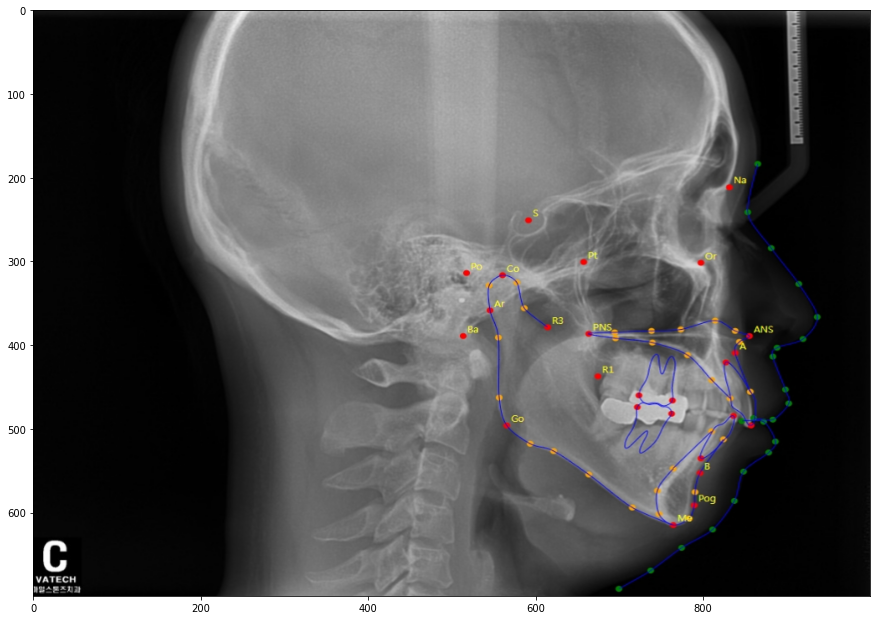

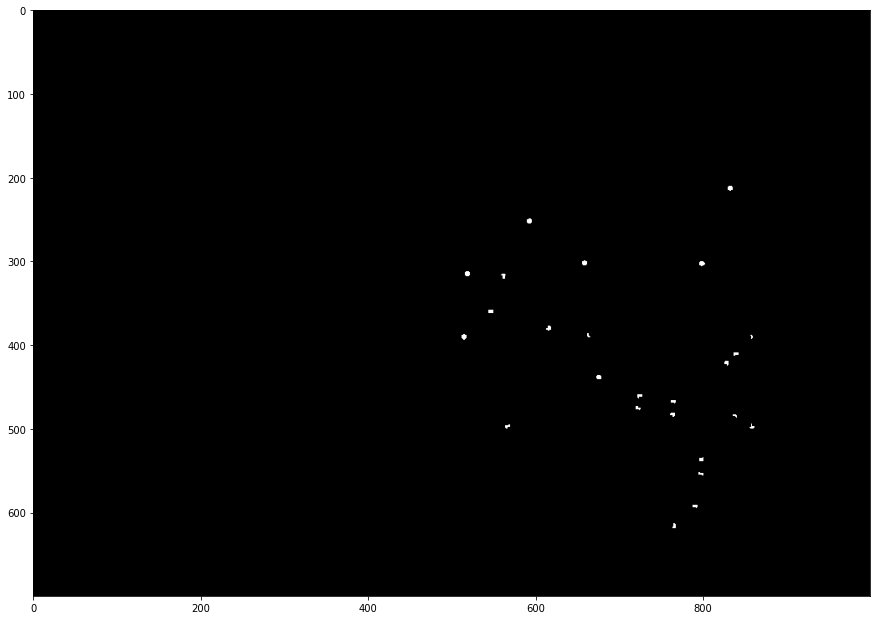

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(images[8])
binary_image = img2binary(images[8])
plt.figure(figsize=(15,15))
plt.imshow(binary_image,cmap='gray')

# Detect Points


## binary2point()
만든 mask의 좌표를 추출하기위해 contour를 적용하고 contour를 통해 나온 좌표들에 mean을 하여 해당 object의 center를 추정하였습니다. 

앞서 만든 binary image로 contour 찾기를 진행합니다. cv2.RETR_EXTERNAL를 이용해 이미지의 가장 바깥쪽인 contour만 추출하고 CHAIN_APPROX_NONE로 contour를 구성하는 모든 점을 저장합니다.

이렇게 추출된 contour가 일정 갯수 미만이라면 빨간점이 모두 검출된 것이 아니므로 error를 띄웁니다.



In [ ]:
def binary2point(binary_img): # red 영역만 표시된 binary image

    contour0,_ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #Contour를 통해 최외각의 점만 추출, contour를 추출하고 Contour들간의 상관관계를 추출한다

    if (len(contour0)<22): # 추출된 contour 값이 22개보다 적으면 binary 이미지에서 color picking이 제대로 이행되지 않은것으로 판단한다
        print("ERROR!",len(contour0)) 
        return None

    points=[]

    #각 conour의 x와 y의 평균을 통해 object의 center를 추정
    for i in contour0:
        points.append(np.mean(i,axis=0,dtype="uint64")[0])



    return points #추출된 object의 center들을 반환

In [ ]:
points = binary2point(binary_image)
print(len(points))

25


## make1point()
원래 하나의 점인데 binary이미지를 만드는 과정에서 morphology 연산을 했음에도 하나의 object가 되지 못한 경우를 제거합니다.  
x,y, 좌표의 평균값을 정리한 points 리스트를 이용해 최종 좌표를 추출합니다.
  
distance 함수를 만들어 일정 거리 미만 떨어져 있는 점과 본인 점을 하나의 점으로 인식하고 그 점이 중복되어 리스트 안에 존재하지 않도록 set함수를 이용해 정리해줍니다. 
  
최종 리스트를 만들어 존재하는 점들의 최종 좌표를 추출합니다.

In [ ]:
def midpoint(ptA, ptB):# 두 점의 중점을 구하는 함수
    return np.array([int((ptA[0] + ptB[0]) * 0.5), int((ptA[1] + ptB[1]) * 0.5)])

def distance(ptA,ptB): # 두 점사이의 거리를 구하는 함수
    return cv2.norm(ptA - ptB, cv2.NORM_L2)

def make1point(points):
    middle_set=[]
    del_set = []
    #
    for i in range(len(points)): # binary2point를 통해 추정된 object의 center들을 2개씩 꺼내 거리 비교를 한다
        for j in range(i,len(points)):
            dist=distance(points[i],points[j])
            if (dist<7.0) & (dist != 0.0): # 거리가 7보다 작으면 원래 같은 점인데 Close 연산을 통해 합쳐지지 않아 2개가 된 경우라고 판단한다.
                #print(dist)
                middle_set.append(midpoint(points[i],points[j])) # 두개 점의 중점을 계산하여 추가한다
                del_set.append(i) 
                #print(middle_set)


    del_set = sorted(list(set(del_set)),reverse=True)

    for w in del_set:#거리가 가까운 두 점은 list에서 삭제한다.
        del points[w]

    final_cor=points+middle_set # 거리가 가까운 점은 삭제한 list와 중점을 구해둔 list를 더해 최종 point를 만든다

    return final_cor

In [ ]:
final_points = make1point(points)
print(len(final_points))

25


# Plot our points

앞선 과정들을 거쳐 추출해낸 point가 정확한지 확인하기 위해 추출한 좌표 위에 초록색 점을 찍어 확인합니다. 

## plot_points()

In [ ]:
def plot_points(img): # landmark가 찍힌 image를 preprocessing 함수를 거쳐 입력
   
    point=binary2point(img2binary(img))
    WANT=make1point(point) # 위 함수들을 거친후 최종 point를 얻는다

    for i in WANT:
        cv2.circle(img, tuple(i), 3, (0,255,0), -1) #이미지에 초록색 점을 찍는다

    return img # 초록색 점이 찍힌 image를 반환

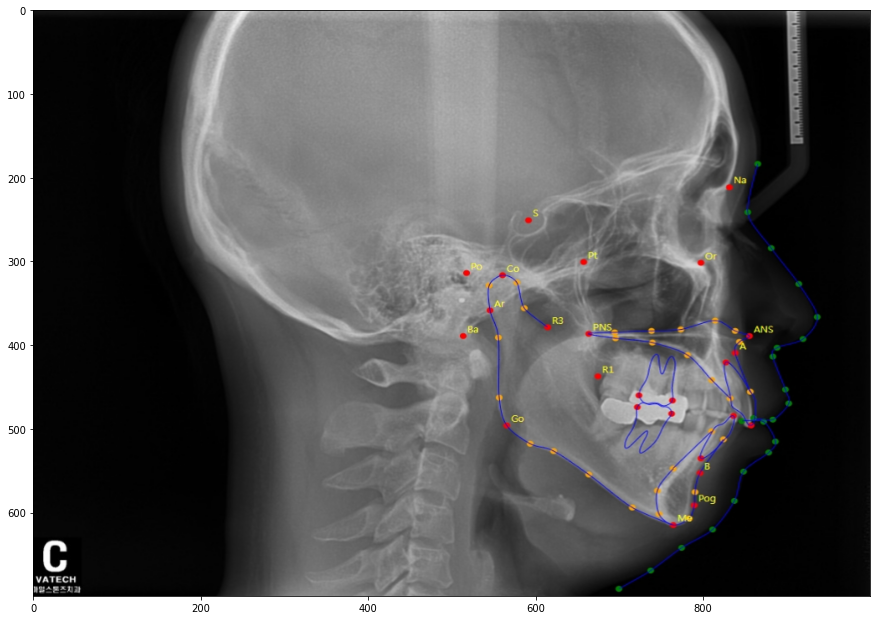

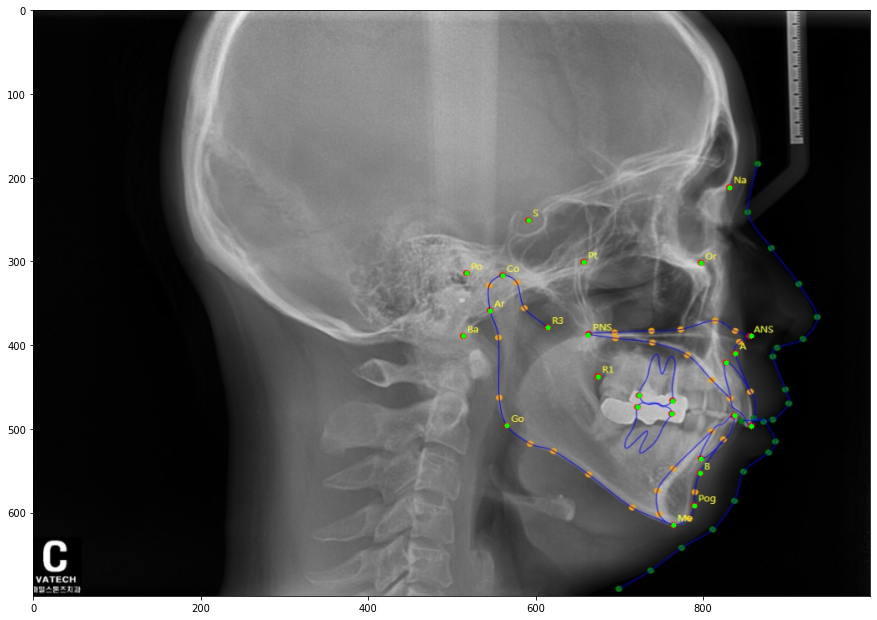

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(images[8])
plt.figure(figsize=(15,15))
plt.imshow(plot_points(images[8]))

# Make Cropped image

점의 최종 좌표를 기준으로 위로 15픽셀, 오른쪽으로 29픽셀을 잘라 영단어만 포함된 이미지를 만들어 OCR에 적합한 이미지로 만들었습니다. 

이미지는  numpy array 형태로 리턴됩니다.



## cropped()

In [ ]:
def cropped(img,points): # prepocessing 함수를 거친 landmark 이미지, contour를 통해 추출한 object의 center point
  cropped_images = []
  for k in range(len(points)):
      cropped_img = img[int(points[k][1])-14: int(points[k][1]), int(points[k][0]): int(points[k][0]) + 29] 
      # 빨간 점을 기준으로 위로 15픽셀, 오른쪽으로 29픽셀 사이즈로 image crop
      resized = cv2.resize(cropped_img,dsize=None,fx = 2, fy = 2) 
      # 이 이미지를 딥러닝을 통해 classification 할 것인데, 이미지 크기가 큰 편이 classification 정확도가 높은것을 확인했다.
      # 따라서 crop된 이미지 사이즈를 2배로 늘림
      cropped_images.append(resized)
  return np.array(cropped_images) # crop 후 2배로 resize된 이미지를 반환

# Deeplearning model for OCR
Crop한 이미지를 tesseract를 이용해 OCR를 진행하려 하였으나 만족할만한 성능이 나오지 않았습니다.  
이를 해결하기 위해 deeplearning을 활용하여 classification을 진행하였습니다.  
  
Classificaiton에 사용된 모델은 data argumentation을 이용해 늘린 데이터를 학습하였고,  
k-fold validation을 통해 평균 95% 이상의 정확도를 보이는것으로 확인되었습니다.

## buildmodel()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D,Flatten,MaxPooling2D

# image classification을 위한 딥러닝 모델입니다
def buildmodel():
  model = Sequential()

  model.add(Conv2D(32, 3, 3, activation='relu',input_shape=(28, 58, 3),padding = 'same'))
  model.add(Conv2D(32, 3, 3, activation='relu',padding='same'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(18, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

## OCR()

In [ ]:
# 학습을 완료한 weight를 load하여 crop된 이미지에 대해 prediction을 시행합니다.
def OCR(img,points,folder_name): # crop된 이미지, 해당 이미지의 points, 해당 이미지의 이름
  dic = {'NAME' : [],'Me': [], 'B': [], 'A': [],
                    'Ar': [], 'Na': [], 'ANS': [], 
                    'Co': [], 'Ba': [],  'Go': [], 
                    'PNS': [], 'Pt': [], 'R3': [], 
                    'Or': [], 'S': [], 'Po':[], 'Pog': [], 'R1': [],'None':[]}

  model = buildmodel()
  model.load_weights('/content/drive/Shareddrives/[DIP] Final project_cephalogram/kfold_fold-5_epoch-50_valloss-0.0259189457.h5')
  cropped_imgs=cropped(img,points)
  predicts = model.predict(cropped_imgs)

  labels = ['Go', 'Na', 'None', 'ANS', 'B', 'Co', 'Ar', 'A', 'Ba', 'Me', 'Po', 'R3', 'Or', 'PNS', 'Pt', 'S', 'R1', 'Pog']
  for k in range(len(cropped_imgs)):
    dic[labels[np.argmax(predicts[k])]]=dic[labels[np.argmax(predicts[k])]]+[points[k]] 
    # 각 좌표와 prediction의 결과를 dictionary 형태로 매칭하여 반환합니다.
    dic[labels[np.argmax(predicts[k])]]=sorted(dic[labels[np.argmax(predicts[k])]],key=lambda c : c[0])
  dic['NAME']=folder_name #dictionary에 이미지의 이름을 추가합니다

  return dic

# Make csv
입력받은 dictionary를 csv 형태로 저장합니다.

## make_csv()

In [ ]:
import csv

def make_csv(opened_file,ocr_dicts): #작성할 csv파일 , ocr을 통해 나온 dictionary들
  lab_names = ["NAME", 'Me', 'B', 'A', 'Ar', 'Na', 'ANS', 'Co', 'Ba', 'Go', 'PNS', 'Pt', 'R3', 'Or', 'S', 'Po', 'Pog', 'R1'] # header들
  writer = csv.DictWriter(opened_file,lab_names)
  writer.writeheader()
  for ocr_dict in ocr_dicts:
    writer.writerow({'NAME' : ocr_dict['NAME'],'Me': ocr_dict['Me'][-1], 'B': ocr_dict['B'][-1], 'A': ocr_dict['A'][-1],
                    'Ar': ocr_dict['Ar'][-1], 'Na': ocr_dict['Na'][-1], 'ANS': ocr_dict['ANS'][-1], 
                    'Co': ocr_dict['Co'][-1], 'Ba': ocr_dict['Ba'][-1],  'Go': ocr_dict['Go'][-1], 
                    'PNS': ocr_dict['PNS'][-1], 'Pt': ocr_dict['Pt'][-1], 'R3': ocr_dict['R3'][-1], 
                    'Or': ocr_dict['Or'][-1], 'S': ocr_dict['S'][-1], 'Po': ocr_dict['Po'][-1], 'Pog': ocr_dict['Pog'][-1], 'R1': ocr_dict['R1'][-1]})

# Result
최종적으로 작성한 함수들을 이용해 csv 파일을 작성한 코드입니다.

In [ ]:
f = open('/content/drive/Shareddrives/[DIP] Final project_cephalogram/Location8.csv', 'w', encoding='utf-8')

ocr_dicts = []
for i in range(len(folder_names)):
  print(i)
  ocr_dict= OCR(images[i],make1point(binary2point(img2binary(images[i]))),folder_names[i]) #함수들을 이용해 OCR dictionary들을 만든다
  print(ocr_dict)
  ocr_dicts.append(ocr_dict)
make_csv(f,ocr_dicts) # 만들어진 dictionary들을 csv 파일에 작성한다
  
print('done!!!!!!!!!!!!!!')
f.close()

0
{'NAME': 'S0000', 'Me': [array([757, 626], dtype=uint64)], 'B': [array([787, 558], dtype=uint64)], 'A': [array([830, 411], dtype=uint64)], 'Ar': [array([555, 343], dtype=uint64)], 'Na': [array([819, 222], dtype=uint64)], 'ANS': [array([848, 390], dtype=uint64)], 'Co': [array([572, 309], dtype=uint64)], 'Ba': [array([519, 377], dtype=uint64)], 'Go': [array([561, 501], dtype=uint64)], 'PNS': [array([669, 380], dtype=uint64)], 'Pt': [array([661, 299], dtype=uint64)], 'R3': [array([622, 377], dtype=uint64)], 'Or': [array([790, 316], dtype=uint64)], 'S': [array([601, 243], dtype=uint64)], 'Po': [array([525, 310], dtype=uint64)], 'Pog': [array([783, 599], dtype=uint64)], 'R1': [array([666, 444], dtype=uint64)], 'None': [array([719, 476], dtype=uint64), array([720, 461], dtype=uint64), array([759, 487], dtype=uint64), array([761, 470], dtype=uint64), array([787, 545], dtype=uint64), array([820, 425], dtype=uint64), array([831, 497], dtype=uint64)]}
1
{'NAME': 'S0001', 'Me': [array([848, 587